In [68]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
from torch import as_tensor, from_numpy, argmax, no_grad
import torch.nn.functional as F
from math import ceil
import torch.nn as nn
import torch
import segmentation_models_pytorch as smp
import pandas as pd
from torch.utils.data import DataLoader
import collections
import matplotlib.pyplot as plt
from PIL import Image


In [124]:
import pandas as pd
import numpy as np
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
import cv2 
import torch
from torch.utils.data import DataLoader, Dataset, sampler
import os

HEIGHT = 520
WIDTH = 704

TESTING = False


RESNET_MEAN = (0.485)
RESNET_STD = (0.229)

# (336, 336)
IMAGE_RESIZE = (224, 224)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

class CellDataset_train(Dataset):
    def __init__(self, df):
        if TESTING:
            self.df = df.head(10000)
        else:
            self.df = df
        self.base_path = "train/"
        self.transforms = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5),
                                   ToTensorV2()])
        self.gb = self.df.groupby('id')
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)
        annotations = self.df['annotation'].tolist()
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)
        mask = build_masks(self.df, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))

    def __len__(self):
        return len(self.image_ids)

    
    
class CellDataset_test(Dataset):
    def __init__(self, df):
        if TESTING:
            self.df = df.head(10000)
        else:
            self.df = df
        self.base_path = "train/"
        self.transforms = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   ToTensorV2()])
        self.gb = self.df.groupby('id')
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)
        annotations = self.df['annotation'].tolist()
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)
        mask = build_masks(self.df, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))

    def __len__(self):
        return len(self.image_ids)


In [7]:
import torch.nn as nn
import torch
import torch.nn.functional as F

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()



In [196]:
IMG_HEIGHT_ORGINAL = 520
IMG_WIDTH_ORGINAL = 704
EPOCHS = 2
BATCH_SIZE = 8
DATA_PATH_FULL_IMGS = "train/"
TRAIN_FILE = "train.csv"
TEST_SIZE = 395

df = pd.read_csv(TRAIN_FILE)
test_df = df.head(TEST_SIZE)
train_df = df.tail(len(df)-TEST_SIZE)

ds_train = CellDataset_train(train_df)
dl_train =DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, drop_last=False)


# net = Net()
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = MixedLoss(10.0, 2.0)

n_batches = len(dl_train)

In [198]:
model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    optimizer.zero_grad()
    for batch in dl_train:
        x,y = batch
        output = model(x)
        loss = criterion(output, y)
        
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

Epoch: 0 - Train Loss 2.7121
Epoch: 1 - Train Loss 1.7775


In [199]:
ds_test = CellDataset_test(test_df)
dl_test = DataLoader(ds_test, batch_size=1, num_workers=0, shuffle=False, drop_last=False)

In [200]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

(224, 224)
0.7162095716783217


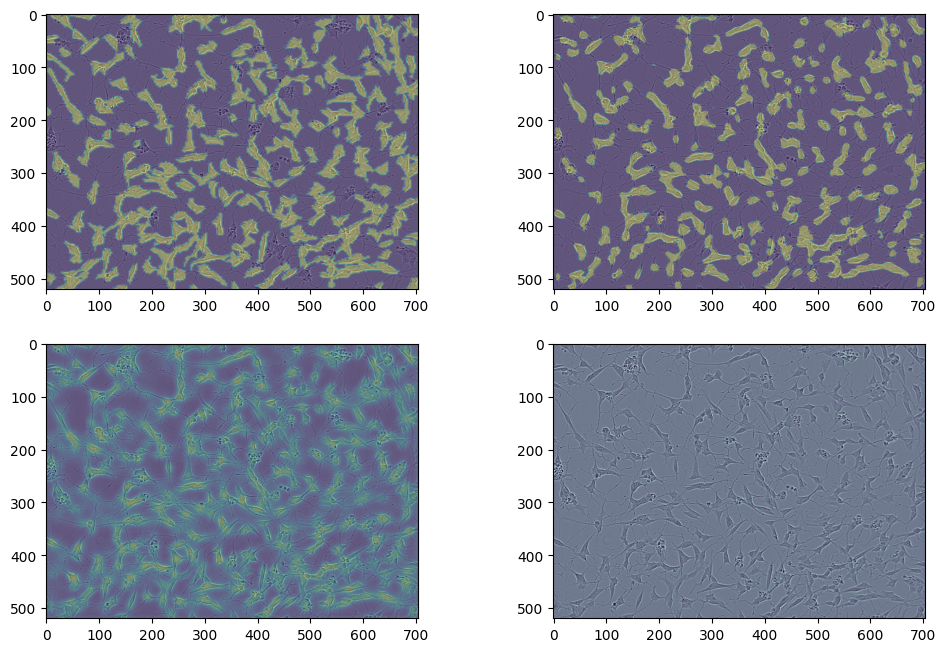

In [218]:
model.eval()
correct = 0
total = 0
f, axarr = plt.subplots(2,2)
image = np.array(Image.open(DATA_PATH_FULL_IMGS + str("0030fd0e6378") + ".png"), dtype= np.uint8)
axarr[0,0].imshow(image, cmap='bone')
axarr[0, 1].imshow(image, cmap='bone')
axarr[1,0].imshow(image, cmap='bone')
axarr[1,1].imshow(image, cmap='bone')
with no_grad():
    for batch in dl_test:
        x, y = batch
        preds = torch.sigmoid(model(x))
        preds = preds.detach().numpy()[:, 0, :, :]
        y = y.detach().numpy()[:, 0, :, :]
        for pred, mask in zip(preds, y):
            probability_mask = cv2.resize(pred, dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
            # predictions = post_process(probability_mask)
            predictions = cv2.threshold(probability_mask, 0.5, 1, cv2.THRESH_BINARY)[1]
            mask = cv2.resize(mask, dsize=(704, 520), interpolation = cv2.INTER_LINEAR)

            a = (predictions == mask)
            print(a.sum()/(520*704))

            axarr[0,0].imshow(mask, alpha=0.3)
            axarr[0,1].imshow(predictions, alpha=0.3)
            axarr[1,0].imshow(probability_mask, alpha=0.3)

plt.show()

In [244]:
transforms = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   ToTensorV2()])

img_folder = "test/"
valid = []
valid_image_ids = []
for file in os.listdir(os.path.join(img_folder)):
    image_id = file
    valid_image_ids.append(image_id)
    image_path = os.path.join(img_folder, image_id)
    image = cv2.imread(image_path)
    image = transforms(image = image)['image']
    valid.append(image)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


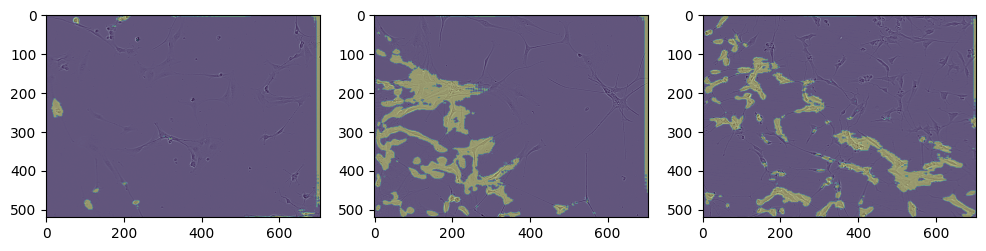

In [232]:
model.eval()

f, axarr = plt.subplots(1,3)

with no_grad():
    for i, (image, idx) in enumerate(zip(valid, valid_image_ids)):
        image = image.view(1,3, 224,224)
        preds = torch.sigmoid(model(image))
        preds = preds.detach().numpy()[0, 0, :, :]
        probability_mask = cv2.resize(preds, dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
        predictions = cv2.threshold(probability_mask, 0.5, 1, cv2.THRESH_BINARY)[1]
        image = np.array(Image.open("test/" + idx), dtype= np.uint8)
        axarr[i].imshow(image, cmap='bone')
        axarr[i].imshow(predictions, alpha=0.3)


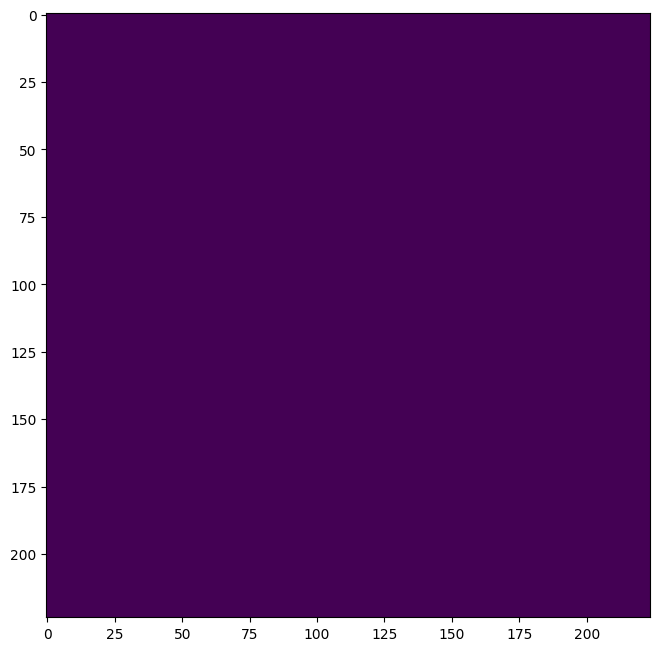

1


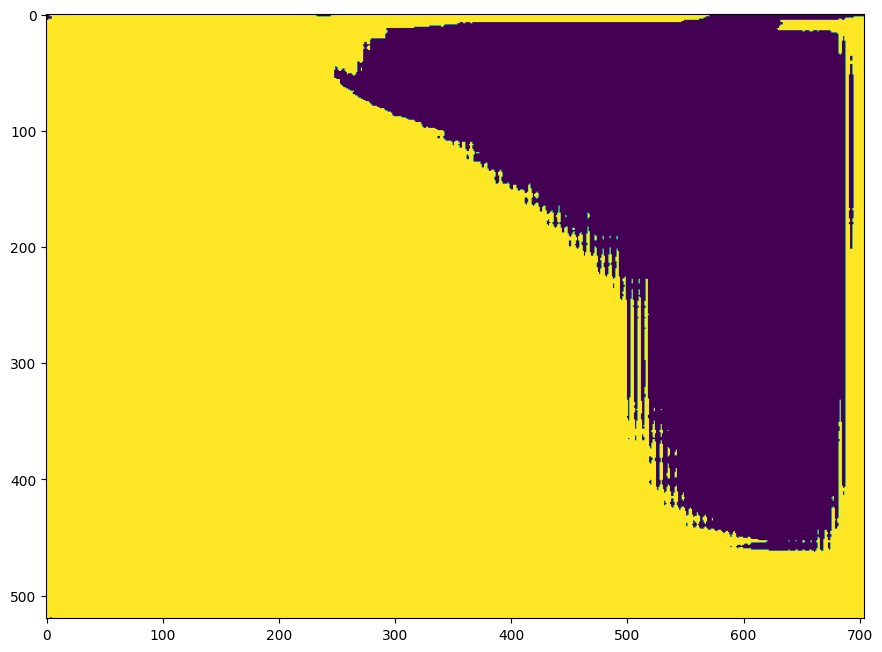

In [258]:
model.eval()


empty = []
empty.append(np.zeros((520, 704, 3), dtype = "uint8"))
for i in range(len(empty)):
    image = empty[i]
    image = transforms(image = image)['image']
    empty[i] = image
    plt.imshow(image[0,:,:])
    plt.show()

with no_grad():
    for i, image in enumerate(empty):
        image = image.view(1,3, 224,224)
        preds = torch.sigmoid(model(image))
        preds = preds.detach().numpy()[0, 0, :, :]
        probability_mask = cv2.resize(preds, dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
        predictions = cv2.threshold(probability_mask, 0.5, 1, cv2.THRESH_BINARY)[1]
        image = np.array(Image.open("test/" + idx), dtype= np.uint8)
        plt.imshow(predictions)
plt.show()